# 양방향 LSTM과 어텐션 메커니즘
- IMDB 리뷰 감성 분류하기

### 1. IMDB 리뷰 데이터 전처리하기

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

In [13]:
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

In [14]:
print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


In [15]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### 2. 바다나우 어텐션(Bahdanau Attention)

In [25]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, values, query): # 단, key와 value는 같음
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### 3. 양방향 LSTM + 어텐션 메커니즘(BiLSTM with Attention Mechanism)

In [17]:
from keras.layers import Dense, Embedding, Bidirectional
from keras.layers import LSTM, Concatenate, BatchNormalization
from keras import Input, Model
from keras import optimizers
import os

#### 함수형 API를 사용하여 모델 설계

In [29]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, 
                               input_length=max_len)(sequence_input)

In [30]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
    (LSTM(128, dropout=0.3, return_sequences=True, return_state=True,
      recurrent_activation='relu',
      recurrent_initializer='glorot_uniform'))(embedded_sequences)

In [31]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [32]:
attention = BahdanauAttention(128) # 가중치 크기 정의
context_vector, attention_weights = attention.call(lstm, state_h)

In [33]:
hidden = BatchNormalization()(context_vector)

In [34]:
output = Dense(1, activation='sigmoid')(hidden)
model = Model(inputs=sequence_input, outputs=output)

AttributeError: 'NoneType' object has no attribute '_inbound_nodes'

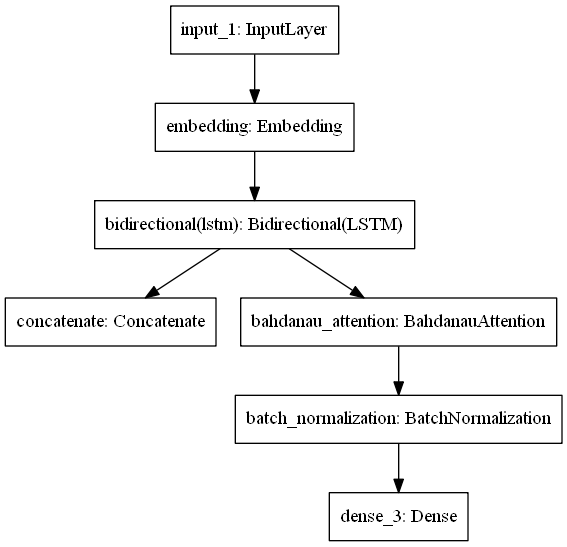

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'image/bilstm.png')

In [14]:
Adam = optimizers.Adam(lr=0.0001, clipnorm=1.)

In [15]:
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs=2, batch_size=64,
                    validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 996s 40ms/sample - loss: 0.6557 - accuracy: 0.5959 - val_loss: 0.5955 - val_accuracy: 0.7477
Epoch 2/2
25000/25000 [==============================] - 786s 31ms/sample - loss: 0.5024 - accuracy: 0.7568 - val_loss: 0.4115 - val_accuracy: 0.8188


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))